# Group Members:
### 🔹 `Muhammad Qambar Hussain CS-23125`

### 🔹 `Asadullah Nizami        CS-23092`

# Import Necassary Libraries

In [ ]:
import random
import math
import time
from typing import List, Optional, Tuple, Generator, Dict
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output


# Board Class
### 🔹 `random_board(self)`
**Purpose:**  
Creates a **random initial assignment** of queens, where each column is assigned a random row.

### 🔹 `count_conflicts(board)`  
**Purpose:**  
Computes the **total number of attacking queen pairs** in **O(N)** time.

### 🔹 `display_board(self, board=None, title="")`
**Purpose:**  
Displays the current board using Matplotlib for visualization during debugging or demonstration.

**Features:**  
- Draws a chessboard pattern  
- Marks queen positions  
- Adjusts figure size dynamically  
- Optionally shows conflict count when visualizing search progress

This method is useful for **inspecting intermediate states** and understanding algorithm behavior.


In [14]:
class Board:
    def __init__(self, N:int = 8, seed:Optional[int]=None):
        self.N = N
        self.seed = seed
        if seed is not None:
            random.seed(seed)
        self.board = self.random_board()

    def random_board(self) -> List[int]:
        return [random.randint(0, self.N - 1) for _ in range(self.N)]

    #O(N)
    @staticmethod
    def count_conflicts(board: List[int]) -> int:
        N = len(board)
        col_counts = [0] * N
        #main diagonal ; no. of unique main diagonal lines = 2N-1
        main_diag_counts = [0] * (2 * N)
        #anti-diagonal ;  no. of unique anti diagonal lines = 2N-1
        anti_diag_counts = [0] * (2 * N)

        for c, r in enumerate(board):
            col_counts[r] += 1
            #shifted by +N to avoid negative indices
            main_diag_counts[r - c + N] += 1
            anti_diag_counts[r + c] += 1

        conflicts = 0
        for counts in (col_counts, main_diag_counts, anti_diag_counts):
            for cnt in counts:
                if cnt > 1:
                     # combinations of attacking queens = nC2
                    conflicts += cnt * (cnt - 1) // 2
        return conflicts

    def display_board(self, board: Optional[List[int]] = None, title: str = ""):
        if board is None:
            board = self.board
        N = self.N
        conflicts = self.count_conflicts(board)

        if 4 <= N < 8:
            size = 5
        elif 8 <= N < 16:
            size = 8
        elif 16 <= N < 32:
            size = 12
        else:
            size = 14

        plt.figure(figsize=(size, size))
        plt.imshow([[((r + c) % 2) for c in range(N)] for r in range(N)], cmap='gray')
        for c, r in enumerate(board):
            if 0 <= r < N:
                plt.text(c, r, "♛", ha='center', va='center', fontsize=24 if N <= 10 else 14, color='red')
        if str == "Local Search Progress":
          plt.title(f"{title}\nConflicts: {conflicts}")
        plt.axis('off')
        plt.show()



# Local Search (Simulated Annealing + Restarts)

### 🔹 `_local_search_core(...)`  
**Purpose:**  
This is the **core simulated annealing engine**, implemented as a **generator** so it can support both:
- automated execution (run until solution), and  
- step-by-step visualization (yield every iteration).  

**Key responsibilities:**  
- Initialize temperature, cooling schedule, restart policy  
- Generate random successor states  
- Use simulated annealing acceptance rule  
- Handle stagnation and random restarts  
- Yield the current search state after each step (board, conflicts, temperature, etc.)  
- Terminate early when a solution is found  

This method avoids code duplication by acting as the shared logic for both public methods.

---

### 🔹 `local_search_auto(self, **kwargs)`
**Purpose:**  
Runs the search **automatically** until a solution is found or the restart limit is exceeded.

**How it works:**  
- Iterates through `_local_search_core()`  
- Returns the first yielded state where `success == True`  
- If no solution is found, returns the last state produced  

Used for benchmarking, measuring runtime, and comparing with CSP.

---

### 🔹 `local_search_step(self, **kwargs)`
**Purpose:**  
Provides a **step-by-step generator** for animated or interactive visualization.

**Usage:**  
Iterating over this method allows you to inspect:
- conflicts at each step  
- temperature changes  
- how simulated annealing makes moves  
- when restarts occur  

Useful for debugging and GUI-based visualization of the search.


In [16]:
class LocalSearch:
    def __init__(self, board: Board):
        self.board = board

    def _local_search_core(
        self,
        max_steps:int=100000,
        restart_limit:int=25,
        initial_temp:float=1000.0,
        stagnation_limit:int=1000,
        seed:Optional[int]=None
    ) -> Generator[Tuple[Optional[List[int]], dict], None, None]:

        if seed is not None:
            random.seed(seed)
        N = self.board.N
        restarts = 0
        cooling_rate = 1 - 1 / max(1, N)
        start_time = time.time()

        if 4 <= N < 8:
            stagnation_limit = 500
        elif 8 <= N < 16:
            stagnation_limit = 1000
        elif 16 <= N < 32:
            stagnation_limit = 2250
        else:
            stagnation_limit = 5000

        while restarts <= restart_limit:
            steps = 0
            temperature = initial_temp
            current_board = self.board.random_board()
            current_conflicts = Board.count_conflicts(current_board)
            best_conflicts = current_conflicts
            no_improve = 0

            while steps < max_steps:
                # yield current state
                yield current_board, {
                    'success': current_conflicts == 0,
                    'conflicts': current_conflicts,
                    'steps': steps,
                    'restarts': restarts,
                    'temperature': temperature,
                    'runtime': time.time() - start_time
                }

                if current_conflicts == 0:
                    return  # stop generator if solution found

                # pick a random column and row
                col = random.randint(0, N-1)
                new_row = random.randint(0, N-1)
                while new_row == current_board[col]:
                    new_row = random.randint(0, N-1)
                new_board = list(current_board)
                new_board[col] = new_row
                new_conflicts = Board.count_conflicts(new_board)

                delta_e = current_conflicts - new_conflicts
                if delta_e > 0 or math.exp(delta_e / max(1e-12, temperature)) > random.random():
                    current_board = new_board
                    current_conflicts = new_conflicts

                if current_conflicts >= best_conflicts:
                    if temperature < 1e-6:
                        no_improve += 1
                        if no_improve >= stagnation_limit:
                            break
                else:
                    best_conflicts = current_conflicts
                    no_improve = 0

                temperature *= cooling_rate
                steps += 1

            restarts += 1
            yield current_board, {'success': False, 'conflicts': current_conflicts, 'steps': steps, 'restarts': restarts, 'restarted': True}


        yield None, {
            'success': False,
            'conflicts': current_conflicts,
            'steps': steps,
            'restarts': restarts,
            'runtime': time.time() - start_time
        }

    def local_search_auto(self, **kwargs) -> Tuple[Optional[List[int]], dict]:
        result = None
        for board_state, info in self._local_search_core(**kwargs):
            result = (board_state, info)
            if info.get('success'):
                return result
        return result

    def local_search_step(self, **kwargs) -> Generator[Tuple[Optional[List[int]], dict], None, None]:
        return self._local_search_core(**kwargs)



# CSP

## 🔹 `is_consistent(col, row, assignment_local)`  
**Purpose:** Checks whether placing a queen at `(col, row)` is valid w.r.t. current partial assignments.  

It verifies:  
- **No row conflict**  
- **No diagonal conflict**  

Used before trying a value in backtracking.

---

## 🔹 `select_unassigned(domains_local, assignment_local)`  
**Purpose:** Implements the **MRV heuristic** (Minimum Remaining Values).  
Selects the column with the **smallest domain size**, i.e., the most constrained variable.

This dramatically reduces branching by solving the hardest positions first.

---

## 🔹 `order_values(col, domains_local, assignment_local)`  
**Purpose:** Implements the **LCV heuristic** (Least Constraining Value).  
Sorts row choices for a column based on how few future-domain values they eliminate.

Lower-impact = tried earlier → reduces backtracking.

---

## 🔹 `forward_check(col, row, domains_local, N, assignment_local)`  
**Purpose:** Performs **constraint propagation** after choosing a value.  

For each other column, removes:  
- The chosen row  
- Diagonal-conflicting rows  

If any unassigned column becomes domain-empty → dead end → return `None` (forces backtracking).

Critical for performance.

---

## 🔹 `csp_auto(time_limit)`  
**Purpose:** Runs CSP **automatically to completion**, or until timeout.  
A wrapper around recursive backtracking with:  
- MRV  
- LCV  
- Forward checking  

**Returns:**  
- A valid solution as a list of row positions  
- Metadata: steps, runtime, success flag

Used for experiments comparing CSP vs local search.

---

## 🔹 `csp_step(time_limit)`  
**Purpose:** Step-by-step CSP solver as a **generator**.  
Useful for visualizing CSP behavior:  
- partial assignments  
- backtracking events  
- propagation  
- assigned variable count  

Yields a board state (partial or full) + status metadata at every meaningful decision point.

In [ ]:
class CSP:
    def __init__(self, board):
        self.board = board

    @staticmethod
    def is_consistent(col, row, assignment_local):
        #This checks if placing a queen in column 'col' at row 'row' is valid, given the queens already placed in assignment_local
        for c, r in assignment_local.items():
            #row or diagonal conflict
            if r == row or abs(c - col) == abs(r - row):
                return False
        return True

    #Variable Selection (MRV heuristic)
    #Selects which variable (column) to assign next.
    @staticmethod
    def select_unassigned(domains_local, assignment_local):
        candidates = []
        for c in domains_local:
            if c not in assignment_local:
                candidates.append((len(domains_local[c]), c))
        #Sorts by domain size — columns with fewer possible rows come first
        candidates.sort()
        #Picks the column with smallest domain (most constrained variable).
        #Instead of degree heuristic it picks the first after sorting  ---> it makes no special difference for values of N from N=4 to N=64
        return candidates[0][1]

    #Value Ordering (LCV heuristic)
    @staticmethod
    def order_values(col, domains_local, assignment_local):
        def impact(row_val):
            removed = 0
            for c in domains_local:
                #continue if already assigned
                if c in assignment_local or c == col:
                    continue
                for other_row_val in list(domains_local[c]):
                    #Count how many would be eliminated to measure impact (same row or diagonal conflict).
                    if other_row_val == row_val or abs(c - col) == abs(other_row_val - row_val):
                        removed += 1
            return removed

        vals = list(domains_local[col])
        #Sort possible row values so the least restrictive (smallest impact) comes first.
        vals.sort(key=lambda x: impact(x))
        return vals

    #constraint propagation
    @staticmethod
    def forward_check(col, row, domains_local, N, assignment_local):
        #make a copy
        new_domains = {c: set(domains_local[c]) for c in domains_local}
        for c in new_domains:
            #For the current variable (col), fix its domain to {row}
            if c == col:
                new_domains[c] = {row}
                continue
            #prune the domain of other cols ---> propagate the constraint
            #row-constraint
            if row in new_domains[c]:
                new_domains[c].remove(row)

            #diagonal-constraint
            #for the current placed queen (col, row):
            #/ diagonal: all positions where r + c == row + col
            #\ diagonal: all positions where r - c == row - col
            #So the two possible diagonally attacked rows in column col are
            diag1 = row + (c - col)
            diag2 = row - (c - col)
            for dc in (diag1, diag2):
                #if in bounds and not already pruned
                if 0 <= dc < N and dc in new_domains[c]:
                    new_domains[c].remove(dc)
            #If any unassigned column loses all possible rows → contradiction.
            #Return None → signal backtrack needed.
            if len(new_domains[c]) == 0 and c not in assignment_local:
                return None
        return new_domains


    # --- Auto Solver ---
    def csp_auto(self, time_limit: Optional[float] = 10.0) -> Tuple[Optional[List[int]], dict]:
        N = self.board.N
        start_time = time.time()
        #Represents the possible positions of the queen in each column before pruning.
        domains = {c: set(range(N)) for c in range(N)}
        #Tracks current partial solution.
        assignment = {}
        steps = 0

        def backtrack(domains_local, assignment_local):
            #nonlocal allows modifying the steps variable defined outside in the parent function.
            nonlocal steps
            steps += 1
            if time_limit and (time.time() - start_time) > time_limit:
                raise TimeoutError('CSP time limit exceeded')
            #If all columns assigned, we found a valid complete solution
            if len(assignment_local) == N:
                return assignment_local

            col = self.select_unassigned(domains_local, assignment_local)
            for row_val in self.order_values(col, domains_local, assignment_local):
                if self.is_consistent(col, row_val, assignment_local):
                    new_domains = self.forward_check(col, row_val, domains_local, N, assignment_local)
                    if new_domains is not None:
                        assignment_local[col] = row_val
                        result = backtrack(new_domains, assignment_local)
                        if result is not None:
                            return result
                        #backtrack: try some other row_val
                        del assignment_local[col]
            #backrack: try some other variable
            return None

        try:
            sol = backtrack(domains, assignment)
        except TimeoutError:
            return None, {
                'success': False,
                'steps': steps,
                'runtime': time.time() - start_time,
                'timeout': True
            }

        runtime = time.time() - start_time
        if sol is None:
            return None, {'success': False, 'steps': steps, 'runtime': runtime}

        #converting to a simple list that represent the board
        state = [sol[c] for c in range(N)]
        return state, {'success': True, 'steps': steps, 'runtime': runtime}

    # --- Step Solver (Generator) ---
    def csp_step(self, time_limit: Optional[float] = float('inf')) -> Generator[Tuple[Optional[List[int]], dict], None, None]:
        N = self.board.N
        start_time = time.time()
        domains = {c: set(range(N)) for c in range(N)}
        assignment: Dict[int, int] = {}
        steps = 0

        def backtrack_gen(domains_local, assignment_local):
            nonlocal steps
            steps += 1
            if time_limit and (time.time() - start_time) > time_limit:
                raise TimeoutError('CSP time limit exceeded')

            if len(assignment_local) == N:
                state_full = [assignment_local[r] for r in range(N)]
                yield (state_full, {
                    'success': True,
                    'steps': steps,
                    'runtime': time.time() - start_time
                })
                return True

            col = self.select_unassigned(domains_local, assignment_local)
            for row_val in self.order_values(col, domains_local, assignment_local):
                if self.is_consistent(col, row_val, assignment_local):
                    new_domains = self.forward_check(col, row_val, domains_local, N, assignment_local)
                    if new_domains is not None:
                        assignment_local[col] = row_val
                        partial = [
                            assignment_local[c] if c in assignment_local else -1
                            for c in range(N)
                        ]
                        yield (partial, {
                            'success': False,
                            'steps': steps,
                            'runtime': time.time() - start_time,
                            'assigned': len(assignment_local)
                        })

                        done = False
                        try:
                            for res in backtrack_gen(new_domains, assignment_local):
                                yield res
                                if res[1].get('success'):
                                    done = True
                                    break
                        except TimeoutError:
                            raise

                        if done:
                            return True

                        del assignment_local[col]
                        partial_back = [
                            assignment_local[c] if c in assignment_local else -1
                            for c in range(N)
                        ]
                        yield (partial_back, {
                            'success': False,
                            'steps': steps,
                            'runtime': time.time() - start_time,
                            'backtracked': True,
                            'assigned': len(assignment_local)
                        })
            return False

        try:
            gen = backtrack_gen(domains, assignment)
            if gen is None:
                yield (None, {'success': False, 'steps': steps, 'runtime': time.time() - start_time})
                return
            for it in gen:
                yield it
            yield (None, {'success': False, 'steps': steps, 'runtime': time.time() - start_time})
        except TimeoutError:
            yield (None, {
                'success': False,
                'steps': steps,
                'runtime': time.time() - start_time,
                'timeout': True
            })

# Interface

## 🔹 UI Components  
The interface builds several widgets:

### **1. Input Widgets**
- `N_slider` → Selects board size `N` (4–64).  
- `seed_box` → Controls randomness for reproducible results.

These define the starting configuration.

### **2. Algorithm Action Buttons**
- **Auto-Solve (Local Search)**  
- **Step-Mode (Local Search)**  
- **Auto-Solve (CSP)**  
- **Step-Mode (CSP)**  
- **Next Step** (used only in step-mode)  
- **Reset** (restores initial configuration)

These trigger the respective algorithms.

### **3. Output Display**
All results (boards, steps, progress messages) appear in the `output` widget.

---

## 🔹 Internal State Management  
A dictionary named `state` stores:  
- `iterator` → generator object (for step mode)  
- `board_obj` → current `Board` instance  
- `mode` → `"ls"` or `"csp"` to control rendering logic

---

## 🔹 Helper Function: `show_initial()`  
Displays the starting random board when:  
- the UI loads  
- reset is pressed  
- N or seed changes  

---

## 🔹 Auto-Solve Handlers

### **`on_auto_ls()`**
Runs Local Search **fully automatically** using:  
- simulated annealing moves  
- conflict evaluation  
- random restarts  
Shows:  
- initial board  
- final board  
- steps, restarts, runtime  

---

### **`on_auto_csp()`**
Runs CSP solver **automatically**, using:  
- MRV  
- LCV  
- forward checking  
Shows:  
- initial board  
- final solution  
- steps and runtime  

---

## 🔹 Step-Mode Handlers (Interactive)

### **`on_step_ls()`**
Initializes Local Search in step-by-step mode:  
- Returns a generator that produces each move  
- Makes "Next Step" button visible  
- Displays initial board  

---

### **`on_step_csp()`**
Initializes CSP step-by-step mode:  
- Each step shows partial assignments  
- Tracks backtracking  
- Visualizes propagation  

---

## 🔹 Step Execution: `on_next()`  
When "Next Step" is pressed:  
1. Retrieves the next tuple from the generator  
2. Displays progress depending on mode:  
   - **LS** → conflicts, temperature, restarts  
   - **CSP** → assigned variable count, partial board  
3. Handles:  
   - stopping when solution found  
   - generator exhaustion  
   - final display  

---

## 🔹 Reset: `on_reset()`  
Clears the output and restores the initial board.

---

## 🔹 UI Layout  
Elements are arranged using `HBox` and `VBox` for clean alignment.

`display(ui)` shows the complete interactive system.




In [17]:
#DRIVER CODE
def run_interface():
    N_slider = widgets.IntSlider(value=8, min=4, max=64, step=1, description='N:')
    seed_box = widgets.IntText(value=42, description='Seed:')

    auto_ls_btn = widgets.Button(description='Auto-Solve (Local Search)', button_style='success')
    step_ls_btn = widgets.Button(description='Step-Mode (Local Search)', button_style='info')
    auto_csp_btn = widgets.Button(description='Auto-Solve (CSP)', button_style='success')
    step_csp_btn = widgets.Button(description='Step-Mode (CSP)', button_style='info')

    next_btn = widgets.Button(description='Next Step', button_style='primary')
    reset_btn = widgets.Button(description='Reset', button_style='warning')

    output = widgets.Output()
    next_btn.layout.display = 'none'
    state = {'iterator': None, 'board_obj': None, 'mode': None}

    def show_initial(N, seed):
        with output:
            clear_output(wait=True)
            bo = Board(N, seed)
            print(f"Initial configuration (N={N}, seed={seed}):")
            bo.display_board(bo.board, "Initial Board")
            state['board_obj'] = bo

    show_initial(N_slider.value, seed_box.value)

    def on_auto_ls(_):
        with output:
            clear_output(wait=True)
            N = N_slider.value
            seed = seed_box.value
            bo = Board(N, seed)
            ls = LocalSearch(bo)
            state['board_obj'] = bo
            print(f"Initial (N={N}, seed={seed}):")
            bo.display_board(bo.board, "Initial Board")
            print("Running Local Search (auto)...")
            sol, stats = ls.local_search_auto(seed=seed)
            if sol:
                print(f"✅ Solution found in {stats['steps']} steps, restarts: {stats['restarts']}, time: {stats['runtime']:.6f}s")
                bo.display_board(sol, "Local Search Final Solution")
            else:
                print(f"❌ No solution found. Time: {stats.get('runtime', 0):.6f}s")
                bo.display_board(bo.board, "Final Board")

    def on_step_ls(_):
        with output:
            clear_output(wait=True)
            N = N_slider.value
            seed = seed_box.value
            bo = Board(N, seed)
            ls = LocalSearch(bo)
            state.update({'board_obj': bo, 'mode': 'ls', 'iterator': ls.local_search_step(seed=seed)})
            next_btn.layout.display = ''
            print(f"Step mode (Local Search) initialized (N={N}, seed={seed}).")
            bo.display_board(bo.board, "Initial Board")

    def on_auto_csp(_):
        with output:
            clear_output(wait=True)
            N = N_slider.value
            seed = seed_box.value
            bo = Board(N, seed)
            csp_obj = CSP(bo)
            state['board_obj'] = bo
            print(f"Initial (N={N}, seed={seed}):")
            bo.display_board(bo.board, "Initial Board")
            print("Running CSP (auto)...")
            sol, stats = csp_obj.csp_auto(time_limit=30.0)
            if sol:
                print(f"✅ CSP solution found in {stats['steps']} steps, time: {stats['runtime']:.6f}s")
                bo.display_board(sol, "CSP Final Solution")
            else:
                print(f"❌ No CSP solution found. Steps: {stats.get('steps', '?')}, time: {stats.get('runtime', 0):.6f}s")
                bo.display_board(bo.board, "CSP Final Board")

    def on_step_csp(_):
        with output:
            clear_output(wait=True)
            N = N_slider.value
            seed = seed_box.value
            bo = Board(N, seed)
            csp_obj = CSP(bo)
            state.update({'board_obj': bo, 'mode': 'csp', 'iterator': csp_obj.csp_step(time_limit=1000)})
            next_btn.layout.display = ''
            print(f"Step mode (CSP) initialized (N={N}, seed={seed}).")
            bo.display_board(bo.board, "Initial Board")

    def on_next(_):
        with output:
            try:
                item = next(state['iterator'])
            except StopIteration:
                print("Generator exhausted.")
                next_btn.layout.display = 'none'
                return

            board, stats = item
            clear_output(wait=True)
            if board is None:
                print("Search finished without solution.")
                print(stats)
                next_btn.layout.display = 'none'
                return

            if stats.get('success'):
                print(f"✅ Solution found. Steps: {stats.get('steps', '?')}, time: {stats.get('runtime', 0):.6f}s")
                state['board_obj'].display_board(board, "Final Solution")
                next_btn.layout.display = 'none'
                return

            if state['mode'] == 'csp':
                print(f"Assigned: {stats.get('assigned', 0)}, Steps: {stats['steps']}, Time: {stats['runtime']:.6f}s")
                state['board_obj'].display_board(board, "CSP Step (Partial Assignment)")
                return

            if state['mode'] == 'ls':
                print(f"Step: {stats['steps']}, Conflicts: {stats['conflicts']}, Temp: {stats['temperature']:.12f}, Restarts: {stats['restarts']}")
                state['board_obj'].display_board(board, "Local Search Progress")

    def on_reset(_):
        next_btn.layout.display = 'none'
        with output:
            show_initial(N_slider.value, seed_box.value)

    # Button bindings
    auto_ls_btn.on_click(on_auto_ls)
    step_ls_btn.on_click(on_step_ls)
    auto_csp_btn.on_click(on_auto_csp)
    step_csp_btn.on_click(on_step_csp)
    next_btn.on_click(on_next)
    reset_btn.on_click(on_reset)

    controls = widgets.VBox([
        widgets.HBox([N_slider, seed_box]),
        widgets.HBox([auto_ls_btn, step_ls_btn, auto_csp_btn, step_csp_btn, next_btn, reset_btn])
    ])
    ui = widgets.VBox([controls, widgets.HTML('<hr/>'), output])
    display(ui)



run_interface()


# Test Configurations

In [18]:
tests = [
    {'N':8, 'seed': 1, 'name': '8_seed1'},
    {'N':16, 'seed': 1, 'name': '16_seed1'},
    {'N':32, 'seed': 1, 'name': '32_seed1'},
    {'N':8, 'seed': 5, 'name': '8_seed5'},
    {'N':16, 'seed': 5, 'name': '16_seed5'},
    {'N':32, 'seed': 5, 'name': '32_seed5'},
    {'N':8, 'seed': 12, 'name': '8_seed12'},
    {'N':16, 'seed': 12, 'name': '16_seed12'},
    {'N':32, 'seed': 12, 'name': '32_seed12'},
    {'N':8, 'seed': 14, 'name': '8_seed14'},
    {'N':16, 'seed': 14, 'name': '16_seed14'},
    {'N':32, 'seed': 14, 'name': '32_seed14'},
]
results = []
for test in tests:
    N = test['N']
    seed = test['seed']
    bo = Board(N, seed)
    ls = LocalSearch(bo)
    ls_sol, ls_stats = ls.local_search_auto(seed=seed)
    csp = CSP(bo)
    csp_sol, csp_stats = csp.csp_auto(time_limit=30.0)
    results.append({
    'test': test['name'],
    'N': N,
    'seed': seed,
    'ls_success': ls_stats['success'],
    'ls_steps': ls_stats['steps'],
    'ls_runtime': ls_stats['runtime'],
    'csp_success': csp_stats['success'],
    'csp_steps': csp_stats['steps'],
    'csp_runtime': csp_stats['runtime'],
     })



results_df = pd.DataFrame(results)
results_df



,test,N,seed,ls_success,ls_steps,ls_runtime,csp_success,csp_steps,csp_runtime
0,8_seed1,8,1,True,289,0.001909,True,30,0.001096
1,16_seed1,16,1,True,1282,0.017958,True,240,0.014692
2,32_seed1,32,1,True,7645,0.159250,True,91,0.045058
3,8_seed5,8,5,True,808,0.007858,True,30,0.000900
4,16_seed5,16,5,True,1938,0.025417,True,240,0.013942
5,32_seed5,32,5,True,3753,0.073923,True,91,0.023776
6,8_seed12,8,12,True,275,0.001586,True,30,0.000547
7,16_seed12,16,12,True,1644,0.012602,True,240,0.007045
8,32_seed12,32,12,True,4138,0.045749,True,91,0.023738
9,8_seed14,8,14,True,140,0.000786,True,30,0.000507


# Display Plots

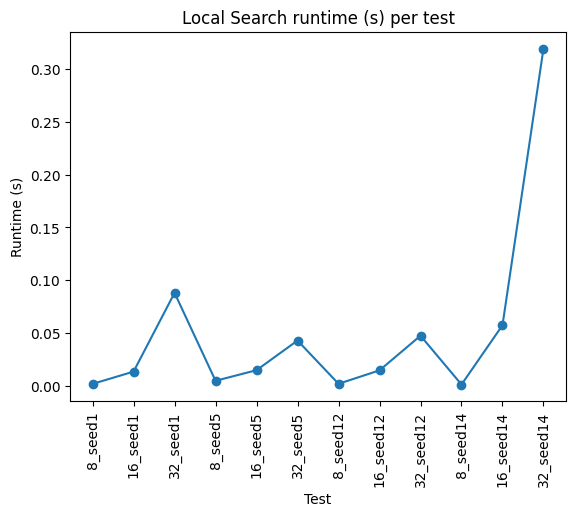

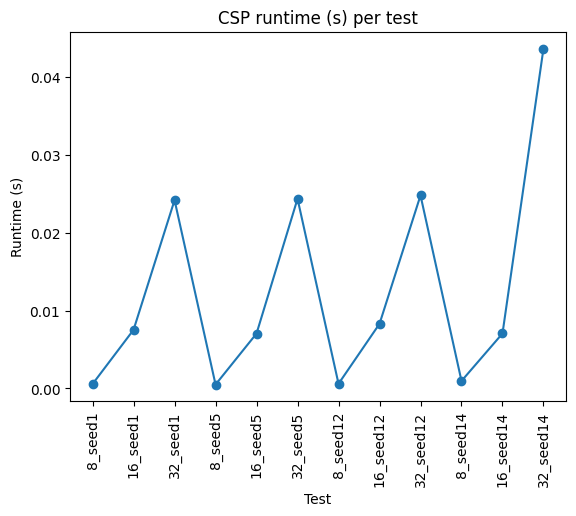

In [13]:
plt.figure()
plt.title('Local Search runtime (s) per test')
plt.plot(results_df['test'], results_df['ls_runtime'], marker='o')
plt.xticks(rotation=90)
plt.xlabel('Test')
plt.ylabel('Runtime (s)')
plt.show()

plt.figure()
plt.title('CSP runtime (s) per test')
plt.plot(results_df['test'], results_df['csp_runtime'], marker='o')
plt.xticks(rotation=90)
plt.xlabel('Test')
plt.ylabel('Runtime (s)')
plt.show()
